# Gradient Boosting Model

HistGradientBoostingClassifier baseline with cross-validation and holdout evaluation on the Grand Prix dataset.


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import balanced_accuracy_score


In [7]:
DATA_PATH = Path('data/grandprix_features_3.csv')
FEATURES = [
    'year',
    'round',
    'avg_race_lap_time_s',
    'lap_delta_vs_event_mean_s',
    'quali_position',
    'prev_points_total',
    'rolling_points_last3',
    'driver_points_per_race',
    'team_prev_points_total',
    'team_points_per_race',
]
TARGET = 'scored_points'
RANDOM_STATE = 42

df = pd.read_csv(DATA_PATH)

# Ensure new feature columns exist even if using older CSV
defaults = {
    'lap_delta_vs_event_mean_s': 0.0,
    'rolling_points_last3': 0.0,
    'driver_points_per_race': 0.0,
    'team_prev_points_total': 0.0,
    'team_points_per_race': 0.0,
}
for col, val in defaults.items():
    if col not in df.columns:
        df[col] = val
print(f"Rows after cleaning: {len(df)}")
df.head()


Rows after cleaning: 1839


,year,round,event,driver,team,quali_position,avg_race_lap_time_s,lap_delta_vs_event_mean_s,finish_position,points_awarded,prev_points_total,rolling_points_last3,driver_points_per_race,team_prev_points_total,team_points_per_race,scored_points
0,2020,1,Austrian Grand Prix,BOT,Mercedes,1.0,68.851635,-1.140119,1.0,25.0,0.0,0.0,0.0,0.0,0.0,1
1,2020,1,Austrian Grand Prix,LEC,Ferrari,7.0,69.497360,-0.494394,2.0,18.0,0.0,0.0,0.0,0.0,0.0,1
2,2020,1,Austrian Grand Prix,NOR,McLaren,4.0,69.444060,-0.547694,3.0,16.0,0.0,0.0,0.0,0.0,0.0,1
3,2020,1,Austrian Grand Prix,HAM,Mercedes,2.0,68.789760,-1.201994,4.0,12.0,0.0,0.0,0.0,25.0,25.0,1
4,2020,1,Austrian Grand Prix,SAI,McLaren,8.0,69.676180,-0.315574,5.0,10.0,0.0,0.0,0.0,16.0,16.0,1


In [8]:
# Load data
print(f'Rows: {len(df)}')
print(df.head())

X = df[FEATURES]
y = df[TARGET].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print('Train/Test shapes:', X_train.shape, X_test.shape)


Rows: 1839
   year  round                event driver      team  quali_position  \
0  2020      1  Austrian Grand Prix    BOT  Mercedes             1.0   
1  2020      1  Austrian Grand Prix    LEC   Ferrari             7.0   
2  2020      1  Austrian Grand Prix    NOR   McLaren             4.0   
3  2020      1  Austrian Grand Prix    HAM  Mercedes             2.0   
4  2020      1  Austrian Grand Prix    SAI   McLaren             8.0   

   avg_race_lap_time_s  lap_delta_vs_event_mean_s  finish_position  \
0            68.851635                  -1.140119              1.0   
1            69.497360                  -0.494394              2.0   
2            69.444060                  -0.547694              3.0   
3            68.789760                  -1.201994              4.0   
4            69.676180                  -0.315574              5.0   

   points_awarded  prev_points_total  rolling_points_last3  \
0            25.0                0.0                   0.0   
1          

In [9]:
# HistGradientBoosting pipeline
hgb = make_pipeline(
    SimpleImputer(strategy='median'),
    HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.05,
        max_depth=5,
        max_iter=400,
        random_state=RANDOM_STATE,
    ),
)

# Fit on training data
hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)
y_proba = hgb.predict_proba(X_test)[:, 1]


print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 (binary):', f1_score(y_test, y_pred))
print('F1 (macro):', f1_score(y_test, y_pred, average="macro"))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))


Precision: 0.8166666666666667
Recall: 0.8076923076923077
F1 (binary): 0.8121546961325967
F1 (macro): 0.8151682571572074
Balanced accuracy: 0.815136476426799


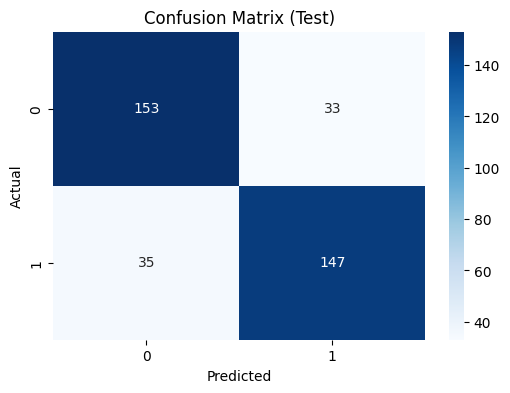

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()